<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Algorithm 1 - Logistic Regression Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Demographic Feature Set </h2> 

# Table of Contents

[Introduction](#setup)  
[No Sample Weights](#noweights)    
[Sample Weights](#weights)  
[Cross-Validation and Parameter Tuning](#cross-validation)   
[Logistic Regression Summary](#summary)

# Introduction <a class="anchor" id="setup"></a>

Initially, we will import the necessary libraries for this notebook. It is essential to mention that some customized libraries from this project are included, which possess functions that we have developed to assist in loading and handling data and storing model outcomes.

Moreover, the variables `COUNTRY` and `ALGORITHM_NAME` are set here to guarantee accurate data loading and a standardized method of storing outcomes.

In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize

ALGORITHM_NAME = 'lr'
COUNTRY = 'dem_merged_dumvar'

TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

# No Sample Weights <a class="anchor" id="noweights"></a>

We first of all run the model without the sample weights to develop a benchmark model 

CPU times: user 108 ms, sys: 527 ms, total: 635 ms
Wall time: 45.4 ms
CPU times: user 0 ns, sys: 121 ms, total: 121 ms
Wall time: 8.29 ms
In-sample score: 78.89%


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


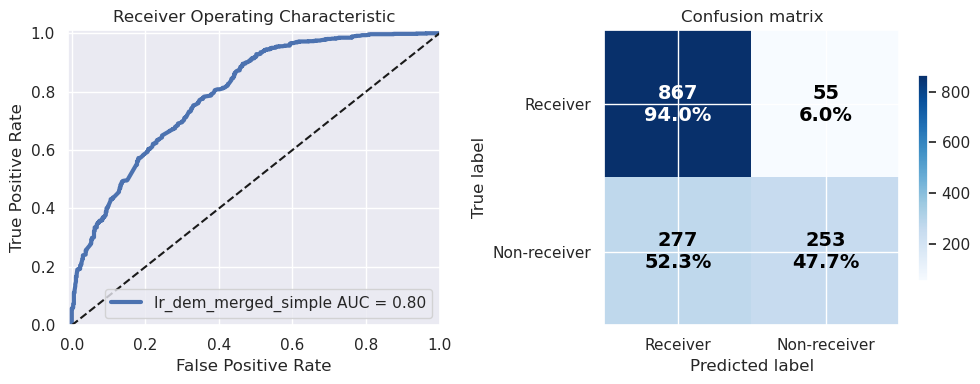

,lr_dem_merged_simple
accuracy,0.771350
recall,0.940347
precision,0.757867
f1,0.839303
cross_entropy,0.502730
roc_auc,0.795646
cohen_kappa,0.458535


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 71.23% 


In [2]:
# Load and transform the training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)
y_train = np.ravel(y_train)
standardize(X_train)
X_train = X_train 

# Fit the model
model = LogisticRegression(max_iter=100)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
def get_coefs_df(X, coefs, index=None, sort=True):
    coefs_df = pd.DataFrame(np.std(X, 0) * coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    if sort:
        coefs_df = coefs_df.sort_values('abs', ascending=False)
    return coefs_df

coefs = get_coefs_df(X_train, model.coef_[0])

# Load and transform the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
y_test = np.ravel(y_test)
standardize(X_test)
X_test = X_test

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    store_model=True,
                                    model_name='dem_merged_simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=coefs)

# Sample weights <a class="anchor" id="weights">

Next, we will incorporate the sample weights that came with the dataset, enabling us to generalize our model results to the overall population.

CPU times: user 35.6 ms, sys: 210 ms, total: 246 ms
Wall time: 19.4 ms
CPU times: user 9.73 ms, sys: 16.2 ms, total: 25.9 ms
Wall time: 1.85 ms
In-sample score: 81.99%


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


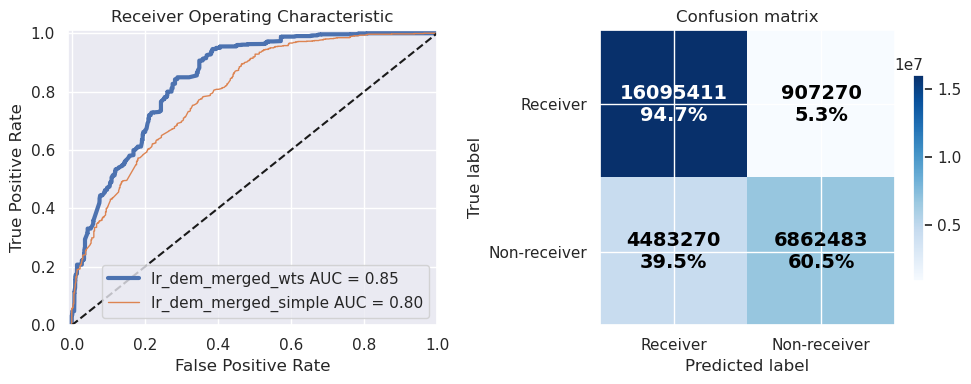

,lr_dem_merged_wts,lr_dem_merged_simple
accuracy,0.809847,0.771350
recall,0.946640,0.940347
precision,0.782140,0.757867
f1,0.856563,0.839303
cross_entropy,0.450266,0.502730
roc_auc,0.845867,0.795646
cohen_kappa,0.469722,0.458535


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 70.37% 


In [3]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression(max_iter=140)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_dem_merged_simple',
                                    store_model=True,
                                    model_name='dem_merged_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)
best_model = model

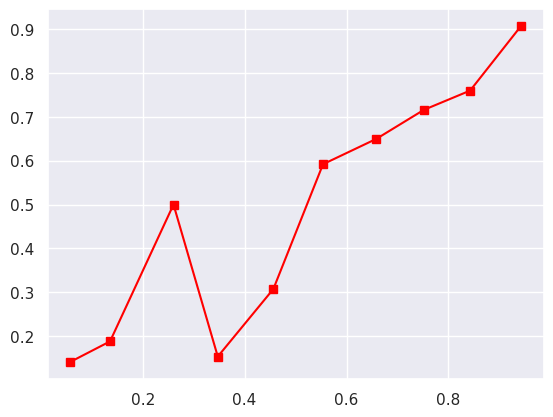

In [4]:
from sklearn.calibration import calibration_curve
y_test_predict_proba = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Uncalibrated')


## Cross-validation and Parameter Tuning <a class="anchor" id="cross-validation"></a>

Cross-validation is a commonly used technique when fitting a model. It involves dividing the training set into several different "folds" and fitting the model to each fold. One variation of the LogisticRegression model that includes cross-validation is available in Scikit-Learn and is called LogisticRegressionCV. This function utilizes stratified k-folds, which ensures that each fold of data has the same proportion of the response variable.

Improving model performance can also be done by tuning its parameters. The default regularization applied by Scikit-learn's LogisticRegression model is 'l2', which includes a 'C' parameter that determines the strength of the regularization. Smaller values of 'C' indicate stronger regularization, which can help in improving model results. To simplify the process of finding the best value for 'C', Scikit-Learn provides the LogisticRegressionCV function that enables us to search through multiple values.  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.2s finished
/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


CPU times: user 1min 24s, sys: 6min 9s, total: 7min 33s
Wall time: 35.2 s
CPU times: user 8.48 ms, sys: 32.9 ms, total: 41.4 ms
Wall time: 2.75 ms
In-sample score: 81.99%
Best model parameters: C=0.0001


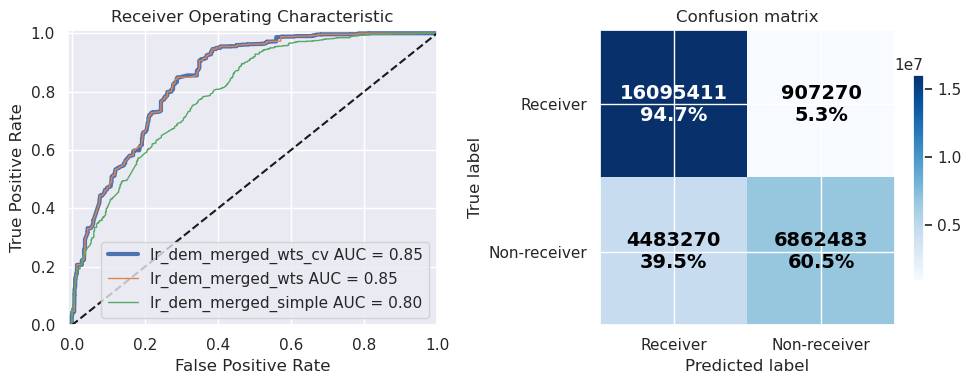

,lr_dem_merged_wts_cv,lr_dem_merged_wts,lr_dem_merged_simple
accuracy,0.809847,0.809847,0.771350
recall,0.946640,0.946640,0.940347
precision,0.782140,0.782140,0.757867
f1,0.856563,0.856563,0.839303
cross_entropy,0.450153,0.450266,0.502730
roc_auc,0.846006,0.845867,0.795646
cohen_kappa,0.469722,0.469722,0.458535


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 70.37% 


In [5]:
from sklearn.linear_model import LogisticRegressionCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegressionCV(Cs=100, cv=100, verbose=1, max_iter=500)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])



# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_dem_merged_wts', 
                                                    'lr_dem_merged_simple'],
                                    store_model=True,
                                    model_name='dem_merged_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

# Logistic Regression Summary <a class="anchor" id="summary"></a>
In this notebook, we have covered the basic concepts of a logistic regression classifier, and applied it to our dataset. We also explored some techniques for analyzing the performance of our model as well as tuning parameters. 

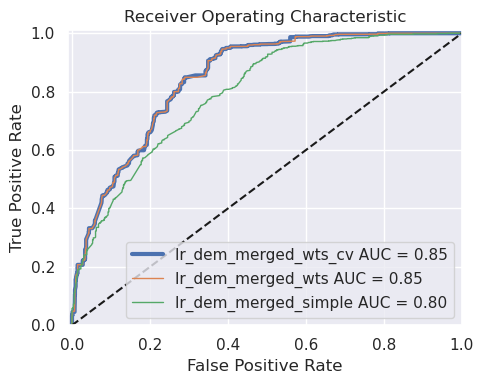

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa
lr_dem_merged_wts_cv,0.809847,0.946640,0.782140,0.856563,0.450153,0.846006,0.469722
lr_dem_merged_wts,0.809847,0.946640,0.782140,0.856563,0.450266,0.845867,0.469722
lr_dem_merged_simple,0.771350,0.940347,0.757867,0.839303,0.502730,0.795646,0.458535


In [6]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)